In [11]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from skimage.color import rgba2rgb
import warnings
warnings.filterwarnings("ignore")


# Define paths
segmented_dir = 'C:/New Project/CNN/Segmentated'
original_dir = 'C:/New Project/CNN/Original'


def load_images(path, is_mask=False):
    images = []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            img = imread(os.path.join(path, filename))
            if img is not None:
                if is_mask:
                    # Check if the mask has an alpha channel and remove it
                    if img.shape[-1] == 4:
                        img = rgba2rgb(img)  # Convert RGBA to RGB
                    img = rgb2gray(img)
                    img = (img >= 0.5).astype(np.float32)  # Threshold grayscale image to create binary mask
                else:
                    img = img[..., :3]  # Discard alpha channel if present
                    img = img / 255.0  # Normalize image pixels to [0, 1]
                images.append(img)
    return np.array(images)


original_images = load_images(original_dir)
segmented_images = load_images(segmented_dir, is_mask=True)


if len(original_images.shape) == 3:
    original_images = np.expand_dims(original_images, axis=-1)
if len(segmented_images.shape) == 3:
    segmented_images = np.expand_dims(segmented_images, axis=-1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(original_images, segmented_images, test_size=0.2, random_state=42)


model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=8)


Epoch 1/15
14/14 [==============================] - 24s 2s/step - loss: 0.6873 - accuracy: 0.8750 - val_loss: 0.6819 - val_accuracy: 0.7293
Epoch 2/15
14/14 [==============================] - 23s 2s/step - loss: 0.6806 - accuracy: 0.6955 - val_loss: 0.6712 - val_accuracy: 0.7298
Epoch 3/15
14/14 [==============================] - 23s 2s/step - loss: 0.6707 - accuracy: 0.6962 - val_loss: 0.6596 - val_accuracy: 0.7308
Epoch 4/15
14/14 [==============================] - 23s 2s/step - loss: 0.6561 - accuracy: 0.7209 - val_loss: 0.6403 - val_accuracy: 0.7503
Epoch 5/15
14/14 [==============================] - 22s 2s/step - loss: 0.6321 - accuracy: 0.7234 - val_loss: 0.6088 - val_accuracy: 0.8058
Epoch 6/15
14/14 [==============================] - 25s 2s/step - loss: 0.5961 - accuracy: 0.8339 - val_loss: 0.5638 - val_accuracy: 0.8899
Epoch 7/15
14/14 [==============================] - 24s 2s/step - loss: 0.5408 - accuracy: 0.9024 - val_loss: 0.4940 - val_accuracy: 0.9392
Epoch 8/15
14/14 [==

In [2]:
# Save the model
model.save('segmentation_model_latest.h5')

C:\Softwares\Anaconda\envs\clouds_modeling\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"





1/1 [==============================] - 0s 491ms/step


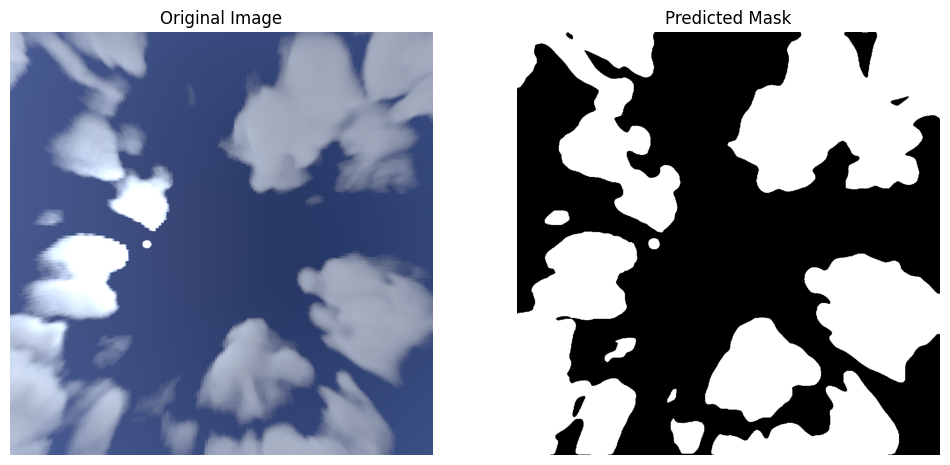

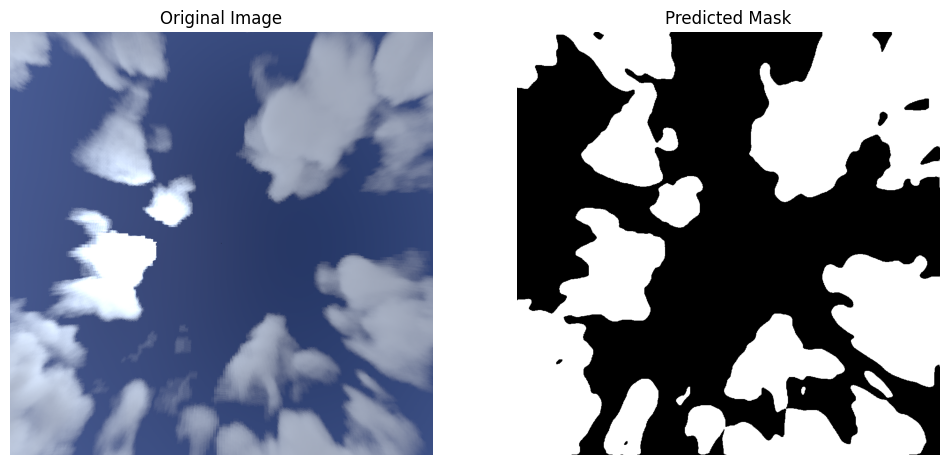

Segmentation completed and combined images saved.


In [1]:
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from skimage.color import rgba2rgb
import warnings
warnings.filterwarnings("ignore")

# Define the path to the new images and the model
test_images_dir = 'C:/New Project/CNN/TEST'
model_path = 'C:/New Project/CNN/segmentation_model_latest.h5'

# Load the trained model
model = load_model(model_path)

# Function to preprocess the new images
def preprocess_new_images(directory, target_size):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.lower().endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = imread(img_path)
            if img.shape[-1] == 4:  # Check for alpha channel and remove it
                img = img[..., :3]
            img = resize(img, target_size, preserve_range=True)  # Resize image to match model input
            img = img / 255.0  # Normalize image to [0, 1]
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

# Replace with the actual size your model expects (height, width, channels)
target_size = (960, 960, 3)

# Load and preprocess the images
new_images, filenames = preprocess_new_images(test_images_dir, target_size)

# Predict the segmentation masks
predicted_masks = model.predict(new_images)

# Threshold the predicted masks to create binary masks
thresholded_masks = (predicted_masks > 0.5).astype(np.uint8)

for i, filename in enumerate(filenames):
    mask = thresholded_masks[i].squeeze() * 255
    mask_filename = os.path.join(test_images_dir, f'{filename}_mask.png')
    #imsave(mask_filename, mask)
    
    # Load original image
    original_image = imread(os.path.join(test_images_dir, filenames[i]))
    
    if len(original_image.shape) != 3 or original_image.shape[2] != 3:
        original_image = np.stack((original_image,) * 3, axis=-1)
    
    if len(mask.shape) == 2:
        # Convert grayscale mask to RGB by repeating the mask across 3 channels
        predicted_mask_rgb = np.stack((mask,) * 3, axis=-1)
    else:
        predicted_mask_rgb = mask
    
    # Check if the dimensions of the original image and the mask match, resize if necessary
    if original_image.shape[:2] != predicted_mask_rgb.shape[:2]:
        predicted_mask_rgb = resize(predicted_mask_rgb, original_image.shape[:2], preserve_range=True).astype(np.uint8)
    
    # Stack the original image and the converted mask
    combined_image = np.hstack((original_image, predicted_mask_rgb))
    
    # Save the combined image
    combined_filename = os.path.join(test_images_dir, f'{filename}_combined.png')
    #imsave(combined_filename, combined_image)


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Use the thresholded mask for display
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

print("Segmentation completed and combined images saved.")

In [2]:
import numpy as np
from skimage.io import imread
import os
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, accuracy_score

def load_ground_truth_masks(ground_truth_dir, target_size):
    masks = []
    filenames = []
    for filename in os.listdir(ground_truth_dir):
        if filename.lower().endswith('.png'):
            mask_path = os.path.join(ground_truth_dir, filename)
            mask = imread(mask_path, as_gray=True)  # Load the ground truth mask
            mask = resize(mask, target_size[:2], preserve_range=True)  # Resize to match the predicted mask size
            mask = (mask > 0.5).astype(np.uint8)  # Threshold to create a binary mask
            masks.append(mask)
            filenames.append(filename)
    return np.array(masks), filenames

# Path to your ground truth masks
ground_truth_dir = 'C:/New Project/CNN/TEST'
ground_truth_masks, gt_filenames = load_ground_truth_masks(ground_truth_dir, target_size)

# Initialize metrics
iou_scores, dice_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], [], []

for i, filename in enumerate(filenames):
    # Ensure both predicted and ground truth masks are binary
    pred_mask = thresholded_masks[i].squeeze()
    gt_mask = ground_truth_masks[i].squeeze()
    
    # Flatten the masks to 1D arrays for metric calculation
    pred_mask_flat = pred_mask.flatten()
    gt_mask_flat = gt_mask.flatten()
    
    # Calculate metrics
    iou = jaccard_score(gt_mask_flat, pred_mask_flat)
    dice = f1_score(gt_mask_flat, pred_mask_flat)
    # precision = precision_score(gt_mask_flat, pred_mask_flat)
    # recall = recall_score(gt_mask_flat, pred_mask_flat)
    # accuracy = accuracy_score(gt_mask_flat, pred_mask_flat)
    
    # Append to lists
    iou_scores.append(iou)
    dice_scores.append(dice)
    # precision_scores.append(precision)
    # recall_scores.append(recall)
    # accuracy_scores.append(accuracy)

# Calculate average metrics
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)
# avg_precision = np.mean(precision_scores)
# avg_recall = np.mean(recall_scores)
# avg_accuracy = np.mean(accuracy_scores)

print(f'mIoU: {round(avg_iou,2)}')
print(f'Average Dice Coefficient: {round(avg_dice,2)}')
# print(f'Average Precision: {round(avg_precision,2)}')
# print(f'Average Recall: {round(avg_recall,2)}')
# print(f'Average Accuracy: {round(avg_accuracy,2)}')

mIoU: 0.86
Average Dice Coefficient: 0.92


####  if Dice Coefficient is high but IoU is low, it might suggest that the model is generally good at capturing the shape and similarity of objects but struggles with precise boundary localization.